In [ ]:
!pip install --upgrade pip


In [30]:
!pip install pandas numpy scikit-learn scipy graphviz shap matplotlib tensorflow sklearn2pmml


Defaulting to user installation because normal site-packages is not writeable
  Using cached sklearn2pmml-0.111.0.tar.gz (7.2 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn2pmml: filename=sklearn2pmml-0.111.0-py3-none-any.whl size=7197126 sha256=335ba031d7883c5ebf4ae9d05c8e9d700ea96e0298664265decb24e774c32c61
  Stored in directory: /home/seba/.cache/pip/wheels/36/d4/3b/6d20e8a7e3a7184ca61d1bc60caa96e5f6ef5551e58a8736c1
Successfully built sklearn2pmml


In [31]:
# Data Processing
import pandas as pd
import numpy as np

from shap import TreeExplainer
from shap import summary_plot
import shap.plots
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.stats import randint
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import svm

from sklearn2pmml import PMMLPipeline
from sklearn2pmml import sklearn2pmml

import matplotlib.pyplot as plt

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [3]:

# fraction = 0.25

# sampled_chunks = []
# chunk_size = 1000000

# for i, chunk in enumerate(pd.read_csv('traces/upb-hyccups2012/upb2012.csv', chunksize=chunk_size)):
#     if i > 3:
#         break
#     # Sample a fraction of rows from each chunk
#     sampled_chunk = chunk.sample(frac=fraction, random_state=1)
#     sampled_chunks.append(sampled_chunk)
# df = pd.concat(sampled_chunks, ignore_index=True)


df = pd.read_csv("traces/upb-hyccups2012/upb2012.csv", nrows=50000)

In [4]:
df

,messageId,messageSource,messageHopCount,oldRelayId,oldFriendWithDestination,oldRelayBattery,oldCommonCommunity,oldDataMemory,newRelayId,newFriendWithDestination,newRelayBattery,newCommonCommunity,newDataMemory
0,0,0,1,5,0,0.333218,0,0.045,0,0,0.730968,0,0.000
1,1,0,1,5,0,0.333218,0,0.045,0,0,0.730968,0,0.000
2,2,0,1,5,0,0.333218,0,0.045,0,0,0.730968,0,0.000
3,3,0,1,5,0,0.333218,0,0.045,0,0,0.730968,0,0.000
4,4,0,1,5,0,0.333218,0,0.045,0,0,0.730968,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1281,5,2,0,0,0.730968,0,0.286,2,0,0.637417,0,0.222
49996,1282,5,2,0,0,0.730968,0,0.286,2,0,0.637417,0,0.222
49997,1283,5,2,0,0,0.730968,0,0.286,2,0,0.637417,0,0.222
49998,1284,5,2,0,0,0.730968,0,0.286,2,0,0.637417,0,0.222


In [5]:
successful_messages = pd.read_csv("traces/upb-hyccups2012/successful2012.csv", nrows=10000)

In [6]:
successful_messages

,messageId,lastRelay,destination
0,14,5,0
1,579,5,0
2,595,5,0
3,604,6,1
4,1176,6,1
...,...,...,...
9995,1797,4,0
9996,1798,4,0
9997,1291,4,0
9998,1864,4,0


In [7]:
df["usefulTransfer"] = np.NaN
df

,messageId,messageSource,messageHopCount,oldRelayId,oldFriendWithDestination,oldRelayBattery,oldCommonCommunity,oldDataMemory,newRelayId,newFriendWithDestination,newRelayBattery,newCommonCommunity,newDataMemory,usefulTransfer
0,0,0,1,5,0,0.333218,0,0.045,0,0,0.730968,0,0.000,NaN
1,1,0,1,5,0,0.333218,0,0.045,0,0,0.730968,0,0.000,NaN
2,2,0,1,5,0,0.333218,0,0.045,0,0,0.730968,0,0.000,NaN
3,3,0,1,5,0,0.333218,0,0.045,0,0,0.730968,0,0.000,NaN
4,4,0,1,5,0,0.333218,0,0.045,0,0,0.730968,0,0.000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1281,5,2,0,0,0.730968,0,0.286,2,0,0.637417,0,0.222,NaN
49996,1282,5,2,0,0,0.730968,0,0.286,2,0,0.637417,0,0.222,NaN
49997,1283,5,2,0,0,0.730968,0,0.286,2,0,0.637417,0,0.222,NaN
49998,1284,5,2,0,0,0.730968,0,0.286,2,0,0.637417,0,0.222,NaN


In [8]:
# make sure column is integer not float
df["usefulTransfer"] = pd.Series(dtype=np.int64)

for index, row in successful_messages.iterrows():
  message_id = row.iloc[0]
  last_relay = row.iloc[1]
  destination = row.iloc[2]

  reached_source = False
  queue = df[(df['messageId'] == message_id) & (df['newRelayId'] == last_relay)].index.tolist()
  visited = []
  while (True):
    if (len(queue) == 0):
       break

    curr_idx = queue.pop()
    visited.append(curr_idx)

    df_row = df.iloc[curr_idx]
    message_source = df_row.iloc[1]
    old_relay_id = df_row.iloc[3]

    if old_relay_id == message_source:
        break

    df.loc[curr_idx, "usefulTransfer"] = 1
    last_relay = old_relay_id


    for idx in df[(df['messageId'] == message_id) & (df['newRelayId'] == last_relay)].index.tolist():
       if (idx not in visited):
         queue.insert(0, idx)

df.loc[(df['usefulTransfer'] != 1), 'usefulTransfer'] = 0
df = df.drop(columns=['messageId', 'oldRelayId', 'newRelayId', 'messageSource'])
df['usefulTransfer'].value_counts()[1]


2663

In [9]:
df.to_csv('traces/upb-hyccups2012/with_result.csv', index=False)


In [10]:
positive_df = df.loc[df['usefulTransfer'] == 1]
negative_df = df.loc[df['usefulTransfer'] == 0].sample(len(positive_df))
balanced_df = pd.concat([positive_df, negative_df], ignore_index=True)
print(balanced_df.min())
print(balanced_df.max())
balanced_df

messageHopCount             0.000000
oldFriendWithDestination    0.000000
oldRelayBattery             0.128897
oldCommonCommunity          0.000000
oldDataMemory               0.047000
newFriendWithDestination    0.000000
newRelayBattery             0.128897
newCommonCommunity          0.000000
newDataMemory               0.000000
usefulTransfer              0.000000
dtype: float64
messageHopCount             6.000000
oldFriendWithDestination    1.000000
oldRelayBattery             0.964487
oldCommonCommunity          1.000000
oldDataMemory               0.808000
newFriendWithDestination    1.000000
newRelayBattery             0.984842
newCommonCommunity          1.000000
newDataMemory               0.813000
usefulTransfer              1.000000
dtype: float64


,messageHopCount,oldFriendWithDestination,oldRelayBattery,oldCommonCommunity,oldDataMemory,newFriendWithDestination,newRelayBattery,newCommonCommunity,newDataMemory,usefulTransfer
0,0,0,0.730968,1,0.047,1,0.637417,0,0.001,1.0
1,0,0,0.730968,1,0.047,1,0.637417,0,0.009,1.0
2,0,0,0.730968,1,0.047,1,0.637417,0,0.019,1.0
3,2,0,0.730968,0,0.047,0,0.637417,0,0.041,1.0
4,2,0,0.637417,0,0.108,0,0.730968,0,0.047,1.0
...,...,...,...,...,...,...,...,...,...,...
5321,5,0,0.385189,0,0.572,0,0.240536,0,0.579,0.0
5322,2,0,0.730968,0,0.119,0,0.637417,0,0.109,0.0
5323,2,0,0.730968,0,0.211,0,0.637417,0,0.187,0.0
5324,0,0,0.385189,1,0.449,0,0.240536,0,0.434,0.0


In [11]:
balanced_df['messageHopCount']

0       0
1       0
2       0
3       2
4       2
       ..
5321    5
5322    2
5323    2
5324    0
5325    2
Name: messageHopCount, Length: 5326, dtype: int64

In [12]:
# add preprocessing
min_max_scaler = MinMaxScaler((0,1))
preprocessed_df = balanced_df.copy()

result_df = pd.DataFrame(balanced_df['usefulTransfer'].copy())
one_hot_encoder = LabelEncoder()
encoded = one_hot_encoder.fit_transform(result_df)
result_df = pd.DataFrame(encoded, columns=['usefulTransfer'])

preprocessed_df = preprocessed_df.drop(columns=['usefulTransfer'])
columns = preprocessed_df.columns
indices = preprocessed_df.index
preprocessed_df['messageHopCount'] = min_max_scaler.fit_transform(preprocessed_df['messageHopCount'].values.reshape(-1,1))
standard_scaler = StandardScaler()
preprocessed_df = standard_scaler.fit_transform(preprocessed_df)
preprocessed_df = pd.DataFrame(preprocessed_df, indices, columns)
preprocessed_df


/home/seba/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,messageHopCount,oldFriendWithDestination,oldRelayBattery,oldCommonCommunity,oldDataMemory,newFriendWithDestination,newRelayBattery,newCommonCommunity,newDataMemory
0,-1.391444,-0.683533,1.283821,2.060896,-1.810907,1.268159,1.073882,-0.307097,-1.907413
1,-1.391444,-0.683533,1.283821,2.060896,-1.810907,1.268159,1.073882,-0.307097,-1.870126
2,-1.391444,-0.683533,1.283821,2.060896,-1.810907,1.268159,1.073882,-0.307097,-1.823518
3,-0.292240,-0.683533,1.283821,-0.485226,-1.810907,-0.788545,1.073882,-0.307097,-1.720978
4,-0.292240,-0.683533,0.885984,-0.485226,-1.517634,-0.788545,1.512242,-0.307097,-1.693013
...,...,...,...,...,...,...,...,...,...
5321,1.356565,-0.683533,-0.186656,-0.485226,0.713162,-0.788545,-0.785829,-0.307097,0.786574
5322,-0.292240,-0.683533,1.283821,-0.485226,-1.464749,-0.788545,1.073882,-0.307097,-1.404038
5323,-0.292240,-0.683533,1.283821,-0.485226,-1.022436,-0.788545,1.073882,-0.307097,-1.040490
5324,-1.391444,-0.683533,-0.186656,2.060896,0.121809,-0.788545,-0.785829,-0.307097,0.110747


In [13]:
result_df

,usefulTransfer
0,1
1,1
2,1
3,1
4,1
...,...
5321,0
5322,0
5323,0
5324,0


In [14]:
preprocessed_df

,messageHopCount,oldFriendWithDestination,oldRelayBattery,oldCommonCommunity,oldDataMemory,newFriendWithDestination,newRelayBattery,newCommonCommunity,newDataMemory
0,-1.391444,-0.683533,1.283821,2.060896,-1.810907,1.268159,1.073882,-0.307097,-1.907413
1,-1.391444,-0.683533,1.283821,2.060896,-1.810907,1.268159,1.073882,-0.307097,-1.870126
2,-1.391444,-0.683533,1.283821,2.060896,-1.810907,1.268159,1.073882,-0.307097,-1.823518
3,-0.292240,-0.683533,1.283821,-0.485226,-1.810907,-0.788545,1.073882,-0.307097,-1.720978
4,-0.292240,-0.683533,0.885984,-0.485226,-1.517634,-0.788545,1.512242,-0.307097,-1.693013
...,...,...,...,...,...,...,...,...,...
5321,1.356565,-0.683533,-0.186656,-0.485226,0.713162,-0.788545,-0.785829,-0.307097,0.786574
5322,-0.292240,-0.683533,1.283821,-0.485226,-1.464749,-0.788545,1.073882,-0.307097,-1.404038
5323,-0.292240,-0.683533,1.283821,-0.485226,-1.022436,-0.788545,1.073882,-0.307097,-1.040490
5324,-1.391444,-0.683533,-0.186656,2.060896,0.121809,-0.788545,-0.785829,-0.307097,0.110747


In [15]:
X = preprocessed_df.copy() # All columns except the last one
y = result_df.copy().squeeze()
print(X.shape)
print(y.shape)

(5326, 9)
(5326,)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Create a PMML pipeline
pipeline = PMMLPipeline([("classifier", rf_classifier)])

# Export the model to PMML
sklearn2pmml(pipeline, "model.pmml")


# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       520
           1       0.86      0.92      0.89       546

    accuracy                           0.88      1066
   macro avg       0.88      0.88      0.88      1066
weighted avg       0.88      0.88      0.88      1066

Confusion Matrix:
[[440  80]
 [ 45 501]]


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
base = svm.SVC(kernel='rbf')

# Hyperparameter tuning using Grid Search
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],  # Kernel coefficient
}

grid_poly = GridSearchCV(base, param_grid, refit=True, cv=5)
grid_poly.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']})

In [18]:
best_svm = grid_poly.best_estimator_
y_pred = best_svm.predict(X_test)
print(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

[1 0 0 ... 0 1 1]
Accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       520
           1       0.87      0.87      0.87       546

    accuracy                           0.86      1066
   macro avg       0.86      0.86      0.86      1066
weighted avg       0.86      0.86      0.86      1066

Confusion Matrix:
[[447  73]
 [ 72 474]]


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(64, input_dim=9, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


trained = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_split=0.2)

Epoch 1/50


/home/seba/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7047 - loss: 0.5504 - val_accuracy: 0.8110 - val_loss: 0.4248
Epoch 2/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.8038 - loss: 0.4286 - val_accuracy: 0.8251 - val_loss: 0.3844
Epoch 3/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.8102 - loss: 0.4022 - val_accuracy: 0.8251 - val_loss: 0.3722
Epoch 4/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.8164 - loss: 0.3855 - val_accuracy: 0.8239 - val_loss: 0.3609
Epoch 5/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.8281 - loss: 0.3672 - val_accuracy: 0.8404 - val_loss: 0.3650
Epoch 6/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - accuracy: 0.8195 - loss: 0.3727 - val_accuracy: 0.8322 - val_loss: 0.3432
Epoch 7/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.8281 - loss: 0.3506 - val_accuracy: 0.8369 - val_loss: 0.3402
Epoch 8/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.8362 - loss: 0.3331 - val_accuracy:

In [20]:
neural_model = trained.model
y_pred = neural_model.predict(X_test)

# Set the threshold
threshold = 0.5

# Convert probabilities to binary labels
y_pred = (y_pred > threshold).astype(int)


# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       520
           1       0.85      0.90      0.88       546

    accuracy                           0.87      1066
   macro avg       0.87      0.87      0.87      1066
weighted avg       0.87      0.87      0.87      1066

Confusion Matrix:
[[435  85]
 [ 52 494]]


In [21]:
explainer = TreeExplainer(rf_classifier, feature_names=preprocessed_df)
shap_values = np.array(explainer.shap_values(X_test))

In [22]:
truncated_shap = shap_values[:20][:][:]
truncated_x = X_test.head(20).to_numpy()

In [23]:
truncated_shap

array([[[-0.43125856,  0.43125856],
        [-0.06716178,  0.06716178],
        [ 0.01496353, -0.01496353],
        [ 0.0323737 , -0.0323737 ],
        [ 0.01266572, -0.01266572],
        [-0.08300065,  0.08300065],
        [-0.02110647,  0.02110647],
        [-0.00339416,  0.00339416],
        [ 0.04217689, -0.04217689]],

       [[ 0.15448758, -0.15448758],
        [ 0.03335291, -0.03335291],
        [ 0.03414571, -0.03414571],
        [ 0.08159855, -0.08159855],
        [ 0.07151167, -0.07151167],
        [-0.04638916,  0.04638916],
        [ 0.0287565 , -0.0287565 ],
        [ 0.00971409, -0.00971409],
        [ 0.12908036, -0.12908036]],

       [[ 0.11134433, -0.11134433],
        [ 0.04793446, -0.04793446],
        [ 0.06750284, -0.06750284],
        [ 0.07135806, -0.07135806],
        [ 0.00706508, -0.00706508],
        [ 0.0741071 , -0.0741071 ],
        [ 0.09123771, -0.09123771],
        [ 0.009134  , -0.009134  ],
        [ 0.01657464, -0.01657464]],

       [[ 0.08841259, 

1


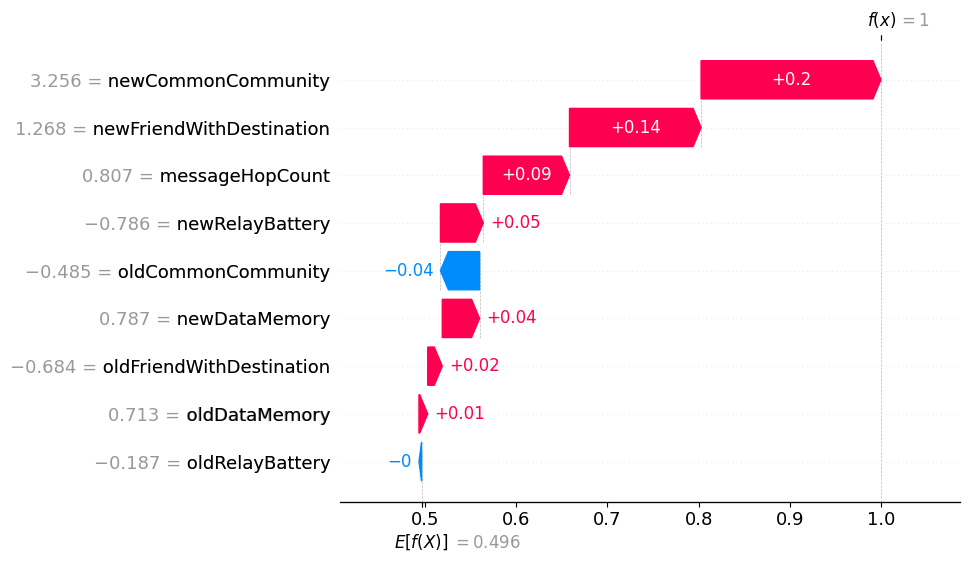

In [24]:

# desired_features = list(balanced_df.columns[:-1])
# for i in range(0, len(desired_features) - 1):
#     for j in range(i+1, len(desired_features)):
#         feature_indices = [i, j]
#         shap_values_subset = shap_values[:, feature_indices]
#         shap_values_subset
#         feat_subset = X_test[list(map(lambda f: desired_features[f], feature_indices))]
#         plt.figure()
#         shap.summary_plot(shap_values_subset, feat_subset, plot_type="bar")
#         display(plt.gcf())
idx = 78
print(y_pred[idx][0])
shap.plots.waterfall(explainer(X_test)[idx,:,y_pred[idx][0]])